In [26]:
# Install gensim and comment it after the first run
#!pip install --no-cache-dir --force-reinstall gensim numpy

# Continue with your imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from gensim.models import Word2Vec
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import datasets

# If the above import fails, it might be that TensorFlow is not installed.
# In that case, uncomment the following line to install TensorFlow.
# !pip install tensorflow

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
df = pd.read_csv('/content/drive/MyDrive/Grammar Correction.csv')

In [29]:
df.head()

,Serial Number,Error Type,Ungrammatical Statement,Standard English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.


In [30]:
# dropping the Serial Number column
df.drop('Serial Number', axis=1, inplace=True)

Text(0, 0.5, 'Error Type')

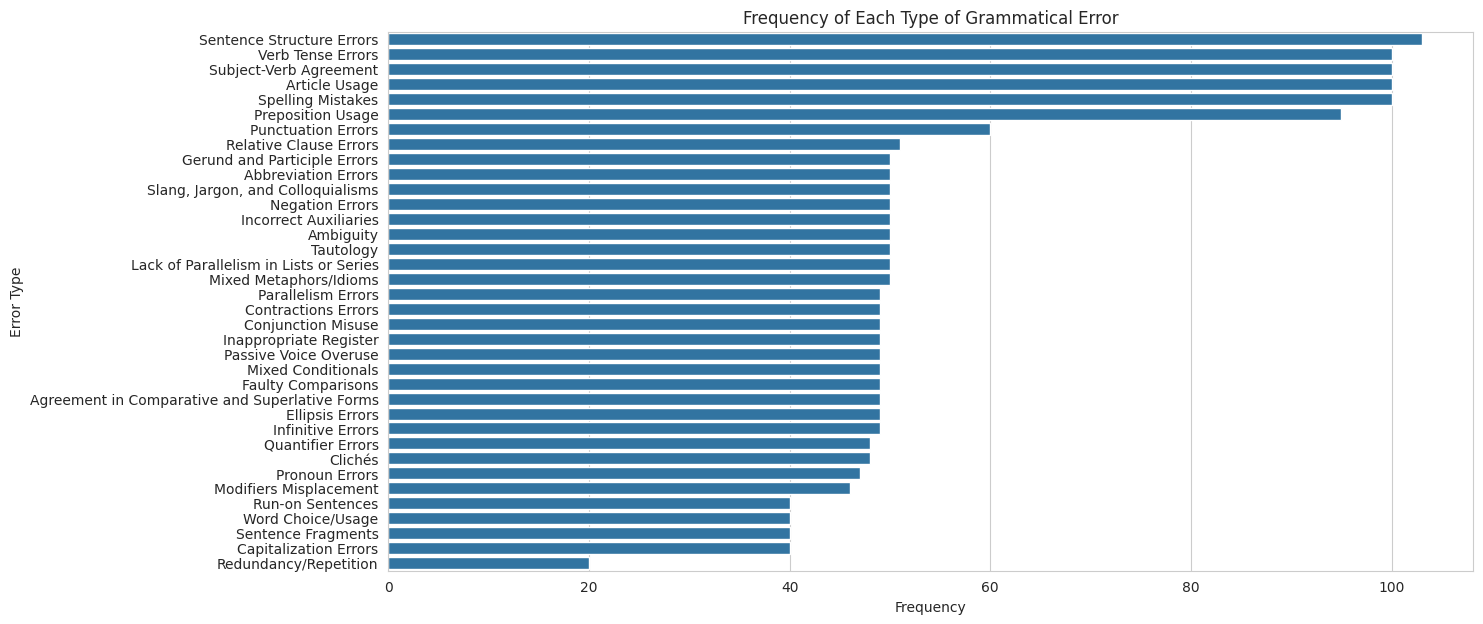

In [31]:
# display the shape of the dataset to understand the number of rows and columns in the dataset
sns.set_style("whitegrid")
plt.figure(figsize = (14, 7))
error_type_plot = sns.countplot(y = df["Error Type"], order = df["Error Type"].value_counts().index)
error_type_plot.set_title("Frequency of Each Type of Grammatical Error")
error_type_plot.set_xlabel("Frequency")
error_type_plot.set_ylabel("Error Type")

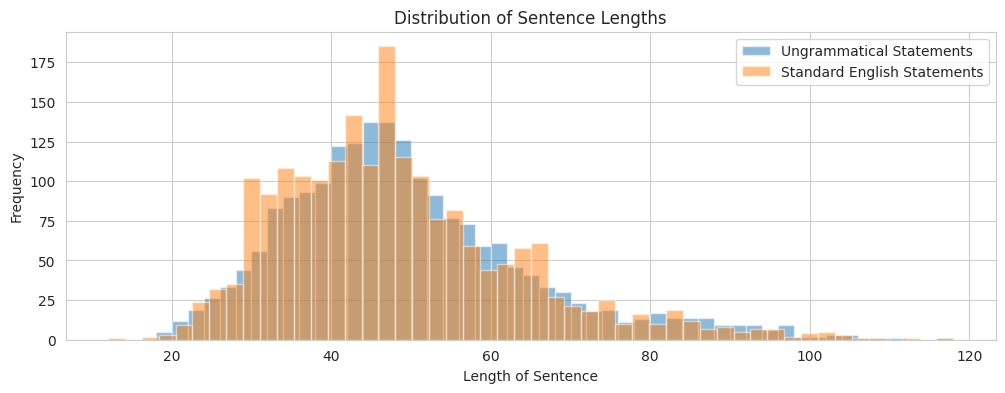

In [32]:
# add the length of the ungrammatical and standard English statements to the dataset
df["Ungrammatical Length"] = df["Ungrammatical Statement"].apply(len)
df["Standard Length"] = df["Standard English"].apply(len)

# display the distribution of sentence lengths for the ungrammatical and standard English statements
plt.figure(figsize = (12, 4))
plt.hist(df["Ungrammatical Length"], bins = 50, alpha = 0.5, label = "Ungrammatical Statements")
plt.hist(df["Standard Length"], bins = 50, alpha = 0.5, label = "Standard English Statements")
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Length of Sentence")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [33]:
# Checking for nulls
df.isnull().sum()

,0
Error Type,0
Ungrammatical Statement,0
Standard English,0
Ungrammatical Length,0
Standard Length,0


In [34]:
# Converting all uppercase to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

<ipython-input-34-d4a5b9817d45>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [35]:
# Define threshold in tokens (words)
threshold_tokens = 20

# Filter by splitting on whitespace and counting tokens
long_sentences = df[
    df['Ungrammatical Statement']
      .str.split()
      .str.len() > threshold_tokens
]

long_sentences.head(5)

,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length
844,mixed metaphors/idioms,"7. i'll cross that bridge when i come to it, b...",7. i'll cross that bridge when i come to it.,93,44
876,mixed metaphors/idioms,39. you can catch more flies with honey than w...,39. you can catch more flies with honey than w...,109,58


In [36]:
# Function to retain only specific punctuation
#  Retains only word characters, whitespace, and . , ?
def retain_selected_punctuation(text):
    if not isinstance(text, str):
        return text
    # 1) remove a leading dot, if present
    text = re.sub(r"^\.", "", text)

    # 2) remove anything that isn't A–Z or a–z, whitespace (\s), question mark ?, apostrophe '
    cleaned = re.sub(r"[^A-Za-z\s,?']+", "", text)
    return cleaned

# Apply the function to the 2 columns
df['Ungrammatical Statement'] = df['Ungrammatical Statement'].apply(retain_selected_punctuation)
df['Standard English'] = df['Standard English'].apply(retain_selected_punctuation)

df.head()

,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length
0,verb tense errors,i goes to the store everyday,i go to the store everyday,29,27
1,verb tense errors,they was playing soccer last night,they were playing soccer last night,35,36
2,verb tense errors,she have completed her homework,she has completed her homework,32,31
3,verb tense errors,he don't know the answer,he doesn't know the answer,25,27
4,verb tense errors,the sun rise in the east,the sun rises in the east,25,26


In [37]:
# Define threshold in tokens (words)
threshold_tokens = 20

# Filter by splitting on whitespace and counting tokens
long_sentences = df[
    df['Ungrammatical Statement']
      .str.split()
      .str.len() > threshold_tokens
]

long_sentences.head(5)

,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length
844,mixed metaphors/idioms,"i'll cross that bridge when i come to it, but...",i'll cross that bridge when i come to it,93,44


In [38]:
# Expand "n't" contractions to "not"
def expand_negations(text):
    if isinstance(text, str):
        # Special cases
        text = re.sub(r"\bwon't\b", "will not", text)
        text = re.sub(r"\bcan't\b", "cannot", text)
        # Generic n't → not (e.g., didn't → did not)
        text = re.sub(r"n\'t\b", " not", text)
    return text

# Apply to both relevant columns
df['Ungrammatical Statement'] = df['Ungrammatical Statement'].apply(expand_negations)
df['Standard English'] = df['Standard English'].apply(expand_negations)

df.head()

,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length
0,verb tense errors,i goes to the store everyday,i go to the store everyday,29,27
1,verb tense errors,they was playing soccer last night,they were playing soccer last night,35,36
2,verb tense errors,she have completed her homework,she has completed her homework,32,31
3,verb tense errors,he do not know the answer,he does not know the answer,25,27
4,verb tense errors,the sun rise in the east,the sun rises in the east,25,26


In [39]:
# Tokenization
def tokenize_text(text):
    """
    Tokenizes text into words (for sentence-level analysis).
    """
    if isinstance(text, str):
        # Tokenize the text into words
        word_tokens = nltk.word_tokenize(text)
        return word_tokens
    else:
        return []

# Apply tokenization to both columns
df['Tokenized Ungrammatical'] = df['Ungrammatical Statement'].apply(tokenize_text)
df['Tokenized Standard'] = df['Standard English'].apply(tokenize_text)

# Display the resulting DataFrame
df.head()


,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length,Tokenized Ungrammatical,Tokenized Standard
0,verb tense errors,i goes to the store everyday,i go to the store everyday,29,27,"[i, goes, to, the, store, everyday]","[i, go, to, the, store, everyday]"
1,verb tense errors,they was playing soccer last night,they were playing soccer last night,35,36,"[they, was, playing, soccer, last, night]","[they, were, playing, soccer, last, night]"
2,verb tense errors,she have completed her homework,she has completed her homework,32,31,"[she, have, completed, her, homework]","[she, has, completed, her, homework]"
3,verb tense errors,he do not know the answer,he does not know the answer,25,27,"[he, do, not, know, the, answer]","[he, does, not, know, the, answer]"
4,verb tense errors,the sun rise in the east,the sun rises in the east,25,26,"[the, sun, rise, in, the, east]","[the, sun, rises, in, the, east]"


In [40]:
# POS-tag each token list

# Explicitly downloading the required resource before using pos_tag
import nltk
try:
    # Attempt to find the resource
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    print("averaged_perceptron_tagger_eng is already downloaded.")
except LookupError:
    # If LookupError occurs, the resource is not found, so download it
    print("averaged_perceptron_tagger_eng not found. Attempting download...")
    try:
        nltk.download('averaged_perceptron_tagger_eng')
        print("Download successful.")
    except Exception as e:
        # Catch any other errors during download
        print(f"Error during download: {e}")
except Exception as e:
    # Catch any other unexpected errors during the initial check
    print(f"An unexpected error occurred: {e}")


df['POS_Ungrammatical'] = df['Tokenized Ungrammatical'] \
    .apply(lambda tokens: nltk.pos_tag(tokens))
df['POS_Standard'] = df['Tokenized Standard'] \
    .apply(lambda tokens: nltk.pos_tag(tokens))

# Inspect:
df.head()

averaged_perceptron_tagger_eng is already downloaded.


,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length,Tokenized Ungrammatical,Tokenized Standard,POS_Ungrammatical,POS_Standard
0,verb tense errors,i goes to the store everyday,i go to the store everyday,29,27,"[i, goes, to, the, store, everyday]","[i, go, to, the, store, everyday]","[(i, NN), (goes, VBZ), (to, TO), (the, DT), (s...","[(i, NN), (go, VBP), (to, TO), (the, DT), (sto..."
1,verb tense errors,they was playing soccer last night,they were playing soccer last night,35,36,"[they, was, playing, soccer, last, night]","[they, were, playing, soccer, last, night]","[(they, PRP), (was, VBD), (playing, VBG), (soc...","[(they, PRP), (were, VBD), (playing, VBG), (so..."
2,verb tense errors,she have completed her homework,she has completed her homework,32,31,"[she, have, completed, her, homework]","[she, has, completed, her, homework]","[(she, PRP), (have, VBP), (completed, VBN), (h...","[(she, PRP), (has, VBZ), (completed, VBN), (he..."
3,verb tense errors,he do not know the answer,he does not know the answer,25,27,"[he, do, not, know, the, answer]","[he, does, not, know, the, answer]","[(he, PRP), (do, VBZ), (not, RB), (know, VB), ...","[(he, PRP), (does, VBZ), (not, RB), (know, VB)..."
4,verb tense errors,the sun rise in the east,the sun rises in the east,25,26,"[the, sun, rise, in, the, east]","[the, sun, rises, in, the, east]","[(the, DT), (sun, NN), (rise, NN), (in, IN), (...","[(the, DT), (sun, NN), (rises, VBZ), (in, IN),..."


In [41]:
# 1) Prepare POS‐tag sequences for BOTH columns
pos_ung = df['POS_Ungrammatical'].apply(lambda sent: [tag for _, tag in sent]).tolist()
pos_std = df['POS_Standard'].   apply(lambda sent: [tag for _, tag in sent]).tolist()

# 2) Train a single Word2Vec on the combined POS sequences
all_pos_seqs = pos_ung + pos_std
pos_w2v = Word2Vec(
    sentences=all_pos_seqs,
    vector_size=50,
    window=3,
    min_count=1,
    workers=4,
    epochs=20
)

# 3) Averaging helper
def avg_pos_embedding(tag_list, model):
    vecs = [model.wv[tag] for tag in tag_list if tag in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

# 4) Apply to both columns
df['POS_W2V_Ungram'] = [
    avg_pos_embedding(tags, pos_w2v) for tags in pos_ung
]
df['POS_W2V_Standard'] = [
    avg_pos_embedding(tags, pos_w2v) for tags in pos_std
]

df.head()

,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length,Tokenized Ungrammatical,Tokenized Standard,POS_Ungrammatical,POS_Standard,POS_W2V_Ungram,POS_W2V_Standard
0,verb tense errors,i goes to the store everyday,i go to the store everyday,29,27,"[i, goes, to, the, store, everyday]","[i, go, to, the, store, everyday]","[(i, NN), (goes, VBZ), (to, TO), (the, DT), (s...","[(i, NN), (go, VBP), (to, TO), (the, DT), (sto...","[-0.09392828, 0.014675111, -0.11880406, -0.019...","[-0.1118876, -0.035431515, -0.12612046, -0.047..."
1,verb tense errors,they was playing soccer last night,they were playing soccer last night,35,36,"[they, was, playing, soccer, last, night]","[they, were, playing, soccer, last, night]","[(they, PRP), (was, VBD), (playing, VBG), (soc...","[(they, PRP), (were, VBD), (playing, VBG), (so...","[-0.08057409, -0.064899, -0.22793531, -0.06408...","[-0.08057409, -0.064899, -0.22793531, -0.06408..."
2,verb tense errors,she have completed her homework,she has completed her homework,32,31,"[she, have, completed, her, homework]","[she, has, completed, her, homework]","[(she, PRP), (have, VBP), (completed, VBN), (h...","[(she, PRP), (has, VBZ), (completed, VBN), (he...","[-0.16420007, -0.030999143, -0.17860003, -0.12...","[-0.14264889, 0.029128814, -0.16982034, -0.094..."
3,verb tense errors,he do not know the answer,he does not know the answer,25,27,"[he, do, not, know, the, answer]","[he, does, not, know, the, answer]","[(he, PRP), (do, VBZ), (not, RB), (know, VB), ...","[(he, PRP), (does, VBZ), (not, RB), (know, VB)...","[-0.20836382, -0.0007793922, -0.24012117, -0.1...","[-0.20836382, -0.0007793922, -0.24012117, -0.1..."
4,verb tense errors,the sun rise in the east,the sun rises in the east,25,26,"[the, sun, rise, in, the, east]","[the, sun, rises, in, the, east]","[(the, DT), (sun, NN), (rise, NN), (in, IN), (...","[(the, DT), (sun, NN), (rises, VBZ), (in, IN),...","[-0.1375149, -0.03588668, -0.17903697, 0.03953...","[-0.20369309, 0.07276149, -0.13043068, 0.02177..."


In [42]:
df['POS_seq_U'] = df['POS_Ungrammatical'].apply(lambda sent: " ".join(tag for _, tag in sent))
df['POS_seq_S'] = df['POS_Standard'].   apply(lambda sent: " ".join(tag for _, tag in sent))

In [43]:
# 1) Prepare token lists
all_tokens = df['Tokenized Ungrammatical'].tolist() + df['Tokenized Standard'].tolist()

# 2) Train Word2Vec
w2v = Word2Vec(
    sentences=all_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

# 3) Helper to average embeddings
def avg_w2v(tokens):
    vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v.vector_size)

# 4) Compute and assign
df['W2V_Ungram']   = df['Tokenized Ungrammatical'].apply(avg_w2v)
df['W2V_Standard'] = df['Tokenized Standard'].    apply(avg_w2v)

In [44]:
from nltk.util import ngrams

# Function to generate n-grams from a token list
def generate_ngrams(tokens, n):
    return [' '.join(gram) for gram in ngrams(tokens, n)] if len(tokens) >= n else []

# Generate bigrams
df['Bigrams_Ungrammatical'] = df['Tokenized Ungrammatical'].apply(lambda tokens: generate_ngrams(tokens, 2))
df['Bigrams_Standard'] = df['Tokenized Standard'].apply(lambda tokens: generate_ngrams(tokens, 2))

# Generate trigrams
df['Trigrams_Ungrammatical'] = df['Tokenized Ungrammatical'].apply(lambda tokens: generate_ngrams(tokens, 3))
df['Trigrams_Standard'] = df['Tokenized Standard'].apply(lambda tokens: generate_ngrams(tokens, 3))


In [45]:
# Prepare all bigrams
all_bigrams = df['Bigrams_Ungrammatical'].tolist() + df['Bigrams_Standard'].tolist()
all_bigrams = [b for b in all_bigrams if b]  # Remove empty ones

# Train Word2Vec on bigrams
bigram_w2v = Word2Vec(
    sentences=all_bigrams,
    vector_size=50,
    window=4,
    min_count=1,
    workers=4,
    epochs=10
)


In [46]:
# Prepare all trigrams
all_trigrams = df['Trigrams_Ungrammatical'].tolist() + df['Trigrams_Standard'].tolist()
all_trigrams = [t for t in all_trigrams if t]  # Remove empty ones

# Train Word2Vec on trigrams
trigram_w2v = Word2Vec(
    sentences=all_trigrams,
    vector_size=50,
    window=4,
    min_count=1,
    workers=4,
    epochs=10
)


In [47]:
# Helper function to average n-gram embeddings
def avg_ngram_vec(ngrams, model):
    vecs = [model.wv[ng] for ng in ngrams if ng in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

# Bigrams
df['W2V_Bigrams_Ungrammatical'] = df['Bigrams_Ungrammatical'].apply(lambda x: avg_ngram_vec(x, bigram_w2v))
df['W2V_Bigrams_Standard'] = df['Bigrams_Standard'].apply(lambda x: avg_ngram_vec(x, bigram_w2v))

# Trigrams
df['W2V_Trigrams_Ungrammatical'] = df['Trigrams_Ungrammatical'].apply(lambda x: avg_ngram_vec(x, trigram_w2v))
df['W2V_Trigrams_Standard'] = df['Trigrams_Standard'].apply(lambda x: avg_ngram_vec(x, trigram_w2v))

In [48]:
# # Combine all n-grams
# df['AllNgrams_Ungrammatical'] = df['Bigrams_Ungrammatical'] + df['Trigrams_Ungrammatical']
# df['AllNgrams_Standard'] = df['Bigrams_Standard'] + df['Trigrams_Standard']

# # Train Word2Vec on all n-grams
# all_ngrams = df['AllNgrams_Ungrammatical'].tolist() + df['AllNgrams_Standard'].tolist()
# all_ngrams = [tokens for tokens in all_ngrams if tokens]

# w2v_ngram = Word2Vec(sentences=all_ngrams, vector_size=50, window=4, min_count=1, workers=4, epochs=10)

# # Average vector for each row
# def avg_ngram_vec(tokens):
#     vecs = [w2v_ngram.wv[t] for t in tokens if t in w2v_ngram.wv]
#     return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_ngram.vector_size)

# df['W2V_Ngrams_Ungrammatical'] = df['AllNgrams_Ungrammatical'].apply(avg_ngram_vec)
# df['W2V_Ngrams_Standard'] = df['AllNgrams_Standard'].apply(avg_ngram_vec)


In [49]:
df.head()

,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length,Tokenized Ungrammatical,Tokenized Standard,POS_Ungrammatical,POS_Standard,POS_W2V_Ungram,...,W2V_Ungram,W2V_Standard,Bigrams_Ungrammatical,Bigrams_Standard,Trigrams_Ungrammatical,Trigrams_Standard,W2V_Bigrams_Ungrammatical,W2V_Bigrams_Standard,W2V_Trigrams_Ungrammatical,W2V_Trigrams_Standard
0,verb tense errors,i goes to the store everyday,i go to the store everyday,29,27,"[i, goes, to, the, store, everyday]","[i, go, to, the, store, everyday]","[(i, NN), (goes, VBZ), (to, TO), (the, DT), (s...","[(i, NN), (go, VBP), (to, TO), (the, DT), (sto...","[-0.09392828, 0.014675111, -0.11880406, -0.019...",...,"[-0.26300946, 0.39695683, 0.13605912, 0.053938...","[-0.26916853, 0.40635803, 0.14320455, 0.059786...","[i goes, goes to, to the, the store, store eve...","[i go, go to, to the, the store, store everyday]","[i goes to, goes to the, to the store, the sto...","[i go to, go to the, to the store, the store e...","[-0.014865453, 0.011285488, 0.023132097, 0.008...","[-0.014125735, 0.011163493, 0.021576487, 0.002...","[0.0005325156, -0.009725857, -0.005175512, -0....","[0.0028302954, -0.011065927, -0.005897359, 0.0..."
1,verb tense errors,they was playing soccer last night,they were playing soccer last night,35,36,"[they, was, playing, soccer, last, night]","[they, were, playing, soccer, last, night]","[(they, PRP), (was, VBD), (playing, VBG), (soc...","[(they, PRP), (were, VBD), (playing, VBG), (so...","[-0.08057409, -0.064899, -0.22793531, -0.06408...",...,"[-0.31353074, 0.4317571, 0.14008799, 0.0459583...","[-0.2976561, 0.4338199, 0.14537303, 0.05446949...","[they was, was playing, playing soccer, soccer...","[they were, were playing, playing soccer, socc...","[they was playing, was playing soccer, playing...","[they were playing, were playing soccer, playi...","[-9.9777804e-05, -0.00026923325, -0.0010527767...","[-0.0039025173, 0.0011602575, 0.004900977, -0....","[0.0038320364, -0.009655613, -0.0017034016, -0...","[0.00012495648, -0.008713345, -0.00053851306, ..."
2,verb tense errors,she have completed her homework,she has completed her homework,32,31,"[she, have, completed, her, homework]","[she, has, completed, her, homework]","[(she, PRP), (have, VBP), (completed, VBN), (h...","[(she, PRP), (has, VBZ), (completed, VBN), (he...","[-0.16420007, -0.030999143, -0.17860003, -0.12...",...,"[-0.2676565, 0.39776075, 0.14841112, 0.0489054...","[-0.28929004, 0.39424703, 0.13514736, 0.038457...","[she have, have completed, completed her, her ...","[she has, has completed, completed her, her ho...","[she have completed, have completed her, compl...","[she has completed, has completed her, complet...","[-0.010381114, -0.005109463, 0.006101277, -0.0...","[-0.011039613, -0.0073119206, -0.006550143, 0....","[0.0067466437, 0.008279691, -0.008719491, -0.0...","[-0.004414208, -0.004460659, 0.010749339, 0.00..."
3,verb tense errors,he do not know the answer,he does not know the answer,25,27,"[he, do, not, know, the, answer]","[he, does, not, know, the, answer]","[(he, PRP), (do, VBZ), (not, RB), (know, VB), ...","[(he, PRP), (does, VBZ), (not, RB), (know, VB)...","[-0.20836382, -0.0007793922, -0.24012117, -0.1...",...,"[-0.31522754, 0.4564127, 0.18422635, 0.0633591...","[-0.30345047, 0.43326005, 0.16985984, 0.060665...","[he do, do not, not know, know the, the answer]","[he does, does not, not know, know the, the an...","[he do not, do not know, not know the, know th...","[he does not, does not know, not know the, kno...","[0.014184555, 0.00413721, 0.0020481946, -0.014...","[0.010535791, -0.002048415, 0.0028087865, -0.0...","[0.005712565, 0.0030096334, 0.0025615322, 0.00...","[0.007004955, 0.012993978, 0.0024182086, 0.000..."
4,verb tense errors,the sun rise in the east,the sun rises in the east,25,26,"[the, sun, rise, in, the, east]","[the, sun, rises, in, the, east]","[(the, DT), (sun, NN), (rise, NN), (in, IN), (...","[(the, DT), (sun, NN), (rises, VBZ), (i

In [50]:
df.to_csv("Grammar_autocorrection_df1_new.csv", index=False)

In [51]:
df.to_pickle("full_featured_dataset.pkl")
